Continued from Part 3 Word2Vec

This time we turn each review into a vector representation using Doc2Vec algoritm (https://radimrehurek.com/gensim/models/doc2vec.html)

In [1]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, LabeledSentence
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, Normalizer

First, load the processed data from Part 1

In [2]:
train = pd.read_csv("labeledTrainData.tsv",
                    delimiter="\t",
                    header=0,
                    quoting=3)

unlabeled = pd.read_csv("unlabeledTrainData.tsv",
                        delimiter="\t",
                        header=0,
                        quoting=3)

train_sents = pickle.load(open("train_sents.pickle"))
unlabeled_sents = pickle.load(open("unlabeled_sents.pickle"))

**train** contains class labels ("sentiment", 1 means positive and 0 means negative), while **unlabeled** does not.

In [3]:
train[:5]

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
unlabeled[:5]

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


The corpus on which Doc2Vec model is trained on must be an iterable of **LabeledSentence** object (i.e. a list of words, and a unique sentence ID)

In [5]:
class IMDBReview(object):
    def __init__(self, sents, prefix="TRAIN"):
        self.sents = sents
        self.prefix = prefix
    def __iter__(self):
        for index, sent in enumerate(self.sents):
            yield LabeledSentence(sent.split(), ["%s_%d" % (self.prefix, index)])

Initialize the model and build the vocabulary:

We'll consider two variants of Doc2Vec, Distributed Bag of Words, and Distributed Memory

As Doc2Vec is unsupervised, it can be trained using the **unlabeled** reviews in addition to **train**

We'll project vector representation into 2-D and 1-D space using PCA and Linear Discriminant Analysis, so we can see how well the two classes are separated.

Finally, we'll use a simple linear model LogisticRegression to test out the quality of the vector representation in a binary classification task.

Distributed BOW: Doc2Vec(dbow+w,d300,n5,w10,s0.0001,t8)
standardizer = None, accuracy = 0.881067

standardizer = StandardScaler(copy=True, with_mean=True, with_std=True), accuracy = 0.881600

standardizer = Normalizer(copy=True, norm='l2'), accuracy = 0.881733



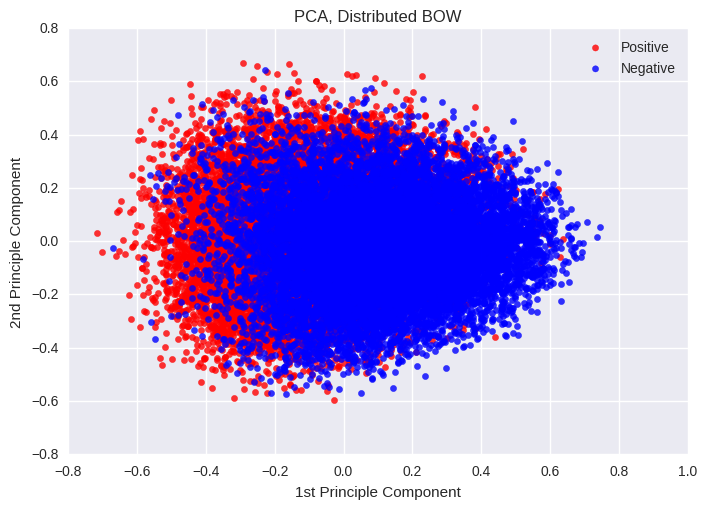

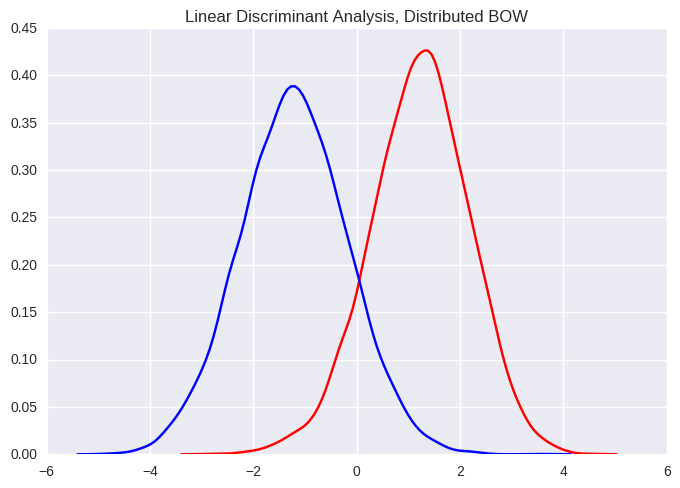

Distributed Memory: Doc2Vec(dm/m,d300,n5,w10,s0.0001,t8)
standardizer = None, accuracy = 0.853200

standardizer = StandardScaler(copy=True, with_mean=True, with_std=True), accuracy = 0.854533

standardizer = Normalizer(copy=True, norm='l2'), accuracy = 0.852000



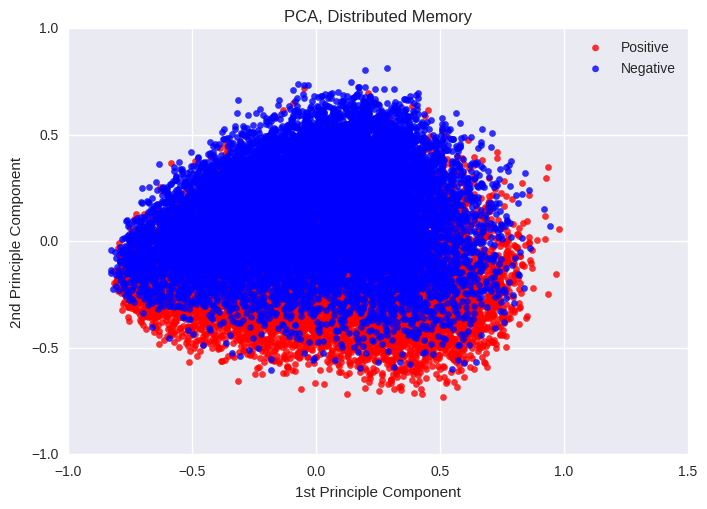

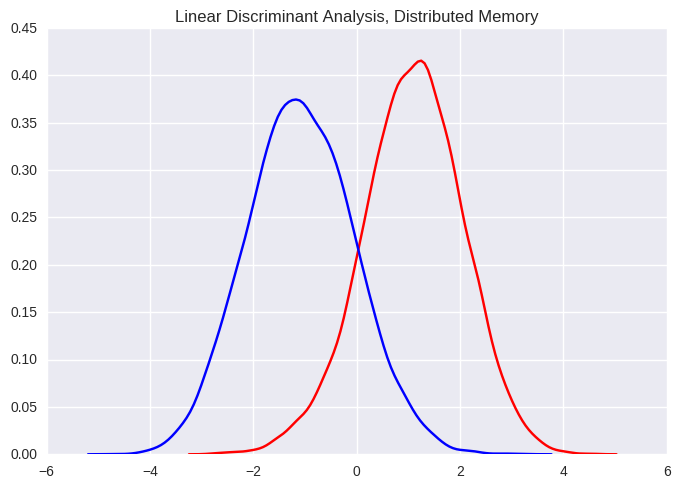

In [6]:
models = [Doc2Vec(dm=0, dbow_words=1, min_count=1, window=10, size=300, sample=1e-4, iter=12, workers=8), # distributed 
          Doc2Vec(dm=1, dm_mean=1, min_count=1, window=10, size=300, sample=1e-4, iter=12, workers=8)] # Distributed Memory

names = ["Distributed BOW", "Distributed Memory"]
dfs = []
for model, name in zip(models, names):
    print "%s: %s" % (name, str(model))
    model.build_vocab(IMDBReview(train_sents))

    corpus = IMDBReview(train_sents)
    model.train(corpus)
    corpus = IMDBReview(unlabeled_sents, prefix="UNLABELED")
    model.train(corpus)
    
    X = np.array([model.docvecs["TRAIN_%d" % i] for i in range(len(train_sents))])
    y = train["sentiment"].values

    for standardizer in [None, StandardScaler(), Normalizer()]:
        if standardizer is not None:
            X = standardizer.fit_transform(X)
    
        lr = LogisticRegression(random_state=42)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        print "standardizer = %s, accuracy = %f\n" % (str(standardizer), 
                                                      lr.fit(X_train, y_train).score(X_test, y_test))
    
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)
    labels = ["positive", "negative"]
    for color, i, label in zip(["red", "blue"], [1, 0], labels):
        plt.scatter(X_r[y==i, 0], X_r[y==i, 1], color=color, alpha=0.8, label=label)
    plt.xlabel("1st Principle Component")
    plt.ylabel("2nd Principle Component")
    plt.legend(["Positive", "Negative"])
    plt.title("PCA, " + name )
    plt.show()    
    
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_r2 = lda.fit(X, y).transform(X).ravel()
    pos, neg = X_r2[y==1], X_r2[y==0]
    sns.kdeplot(pos, color="red")
    plt.hold(True)
    sns.kdeplot(neg, color="blue")
    plt.legend(["Positive", "Negative"])
    plt.title("Linear Discriminant Analysis, " + name)
    plt.show()